## Prepare chirps data for Pacific Islands

## libraries

In [18]:
import xcast as xc
import xarray as xr
import cartopy.crs as ccrs
import cartopy as cf
import numpy as np
import matplotlib.pyplot as plt
import os
from datetime import datetime

#functions, constants, created in same folder
#import xcast_season_config as cfg
import helper_functions as helper
#automatically reloads the configuration file once updated and saved
%load_ext autoreload
%autoreload 2

In [40]:
season_dict= {
    'JFM': [1,2,3],
    'FMA': [2,3,4],
    'MAM': [3,4,5],
    'AMJ': [4,5,6],
    'MJJ': [5,6,7],
    'JJA': [6,7,8],
    'JAS': [7,8,9],
    'ASO': [8,9,10],
    'SON': [9,10,11],
    'OND': [10,11,12],
    'NDJ': [11,12,1],
    'DJF': [12,1,2]
}

month_number_dict = {
    1: 'J',
    2: 'F',
    3: 'M',
    4: 'A',
    5: 'M',
    6: 'J',
    7: 'J',
    8: 'A',
    9: 'S',
    10:'O',
    11:'N',
    12:'D'}

In [8]:
raw_chirps_dir = '/cpc/int_desk/data/chirps'
trial = xr.open_dataset(os.path.join(raw_chirps_dir, 'chirps-v2.0.2024.days_p05.nc'))
trial

<xarray.Dataset>
Dimensions:    (latitude: 2000, longitude: 7200, time: 121)
Coordinates:
  * latitude   (latitude) float32 -49.97 -49.92 -49.88 ... 49.87 49.92 49.97
  * longitude  (longitude) float32 -180.0 -179.9 -179.9 ... 179.9 179.9 180.0
  * time       (time) datetime64[ns] 2024-01-01 2024-01-02 ... 2024-04-30
Data variables:
    precip     (time, latitude, longitude) float32 ...
Attributes: (12/15)
    Conventions:       CF-1.6
    title:             CHIRPS Version 2.0
    history:           created by Climate Hazards Group
    version:           Version 2.0
    date_created:      2024-05-15
    creator_name:      Pete Peterson
    ...                ...
    reference:         Funk, C.C., Peterson, P.J., Landsfeld, M.F., Pedreros,...
    comments:           time variable denotes the first day of the given day....
    acknowledgements:  The Climate Hazards Group InfraRed Precipitation with ...
    ftp_url:           ftp://chg-ftpout.geog.ucsb.edu/pub/org/chg/products/CH...
    website:           http://chg.geog.ucsb.edu/data/chirps/index.html
    faq:               http://chg-wiki.geog.ucsb.edu/wiki/CHIRPS_FAQ

In [69]:
ds = xr.open_mfdataset(os.path.join(raw_chirps_dir,
                                            'chirps-v2.0.*days_p05.nc'), 
                               combine = "by_coords", 
                               engine = "netcdf4", 
                               chunks={'time': 121, 'latitude': 2000, 'longitude': 720})
monthly = ds.resample(time='1M').mean()
monthly_first =  prepped_predictor_obs = helper.change_dates_to_first(monthly, 'time')
years = helper.getYears(1981,2023)

In [74]:
months = [1,2,3,4,5,6,7,8,9,10,11,12]

seasons = []
for m in months:
    if m == 11:
        season = []
        for y in np.unique(monthly.time.dt.year):
            seas_1 = monthly.sel(time = monthly.time.dt.month.isin([11,12]))
            seas_1 = seas_1.sel(time = seas_1.time.dt.year.isin(y))
            seas_2 = monthly.sel(time = monthly.time.dt.month.isin([1]))
            seas_2 = seas_2.sel(time = seas_2.time.dt.year.isin(y+1))
            season_year =  xr.concat([seas_1, seas_2], dim = 'time').mean(dim = 'time')
            season_year = season_year.expand_dims({'year':int(y)})
            season.append(season_year)
        season = xr.concat(season, dim = 'year')
        season = season.expand_dims({'season':['NDJ']})
    elif m == 12:
        season = []
        for y in np.unique(monthly.time.dt.year):
            seas_1 = monthly.sel(time = monthly.time.dt.month.isin([12]))
            seas_1 = seas_1.sel(time = seas_1.time.dt.year.isin(y))
            seas_2 = monthly.sel(time = monthly.time.dt.month.isin([1,2]))
            seas_2 = seas_2.sel(time = seas_2.time.dt.year.isin(y+1))
            season_year =  xr.concat([seas_1, seas_2], dim = 'time').mean(dim = 'time')
            season_year = season_year.expand_dims({'year':int(y)})
            season.append(season_year)
        season = xr.concat(season, dim = 'year')
        season = season.expand_dims({'season':['DJF']})
    else:
        seas_months = monthly.sel(time = monthly.time.dt.month.isin([m, m+1, m+2]))
        season = seas_months.groupby('time.year').mean()
        season = season.expand_dims({'season':[month_number_dict[m] + month_number_dict[m+1] + month_number_dict[m+2]]})
    season = season.sel(year = season.year.isin(years))
    seasons.append(season)
seasons = xr.concat(seasons, dim = 'season')
seasons

<xarray.Dataset>
Dimensions:    (latitude: 2000, longitude: 7200, year: 43, season: 12)
Coordinates:
  * latitude   (latitude) float32 -49.97 -49.92 -49.88 ... 49.87 49.92 49.97
  * longitude  (longitude) float32 -180.0 -179.9 -179.9 ... 179.9 179.9 180.0
  * year       (year) int64 1981 1982 1983 1984 1985 ... 2020 2021 2022 2023
  * season     (season) object 'JFM' 'FMA' 'MAM' 'AMJ' ... 'OND' 'NDJ' 'DJF'
Data variables:
    precip     (season, year, latitude, longitude) float32 dask.array<chunksize=(1, 1, 2000, 720), meta=np.ndarray>
Attributes: (12/15)
    Conventions:       CF-1.6
    title:             CHIRPS Version 2.0
    history:           created by Climate Hazards Group
    version:           Version 2.0
    date_created:      2015-11-20
    creator_name:      Pete Peterson
    ...                ...
    reference:         Funk, C.C., Peterson, P.J., Landsfeld, M.F., Pedreros,...
    comments:           time variable denotes the first day of the given day.
    acknowledgements:  The Climate Hazards Group InfraRed Precipitation with ...
    ftp_url:           ftp://chg-ftpout.geog.ucsb.edu/pub/org/chg/products/CH...
    website:           http://chg.geog.ucsb.edu/data/chirps/index.html
    faq:               http://chg-wiki.geog.ucsb.edu/wiki/CHIRPS_FAQ

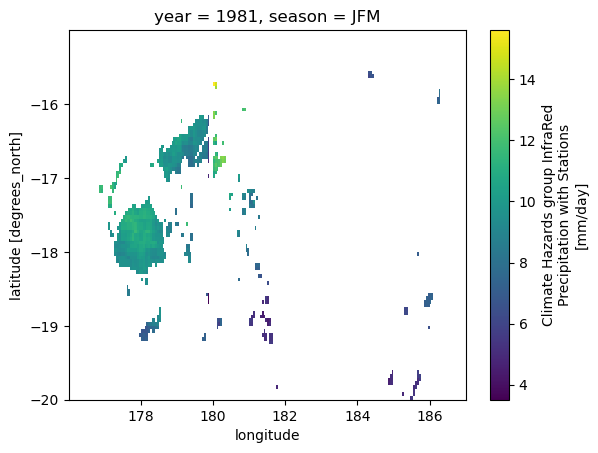

In [84]:
#large predictor zone
large_w=170
large_e=250
large_s=-25
large_n=0

#update coordinates to 0-360 grid
chirps_360 = helper.adjust_longitude_to_360(seasons, 'longitude').sortby('latitude', ascending = False).sortby('longitude', ascending = True)
chirps_pacisl = chirps_360.sortby('longitude', ascending=True).sel(longitude = slice(large_w, large_e),
                              latitude = slice(large_n, large_s))
chirps_pacisl.isel(season=0,year=0).precip.sel(longitude = slice(176, 187),
                              latitude = slice(-15, -20)).plot()